<a href="https://colab.research.google.com/github/caglarmert/DI725/blob/main/DI725_Lab_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DI 725: Transformers and Attention-Based Deep Networks

## A Tutorial for Implementing Transformers in PyTorch

The purpose of this notebook is to introduce the transformers architecture, building different types of transformers and its adaptations to various tasks.

In this notebook, there will be three different tasks, suitable to demonstrate Encoder-Transformer, Decoder-Transformer and Encoder-Decoder Transformer architectures.

### Authors:
* Tuğba Taşkaya Temizel: ttemizel metu.edu.tr
* Alptekin Temizel: atemizel metu.edu.tr
* Ümit Mert Çağlar: mecaglar metu.edu.tr

# Introduction

## Attention Is All You Need

The paper [Attention Is All You Need](https://arxiv.org/abs/1706.03762), by Vaswani et al. changed the deep learning scene, starting with the NLP tasks, spanning almost all other aspects of deep learning studies, including vision and time series tasks. The emphasis of this paper is on attention and the carefully designed well-known and proven components. We will begin by examining the figure (provided by the author) and understand every component in the so-called transformer architecture.

---
<div>
<img src="https://github.com/caglarmert/DI725/blob/main/src/attention_research_1.png?raw=true" width="400"/>
</div>

---
Just by observing the architecture we can spot some important aspects of the Transformer architecture.
* First, we have [embeddings](https://arxiv.org/abs/1608.05859) at the input and
output, these are required in many tasks, to transform data into high dimensional vectors.
* Second, we have [Positional Encoding](https://arxiv.org/pdf/1705.03122.pdf), which we require for the Transformer model to understand and relate the relative position of input and output tokens or embeddings.
* On the left-hand side, we have the Encoder structure, which is a stacked network (depicted with Nx), that has the subcomponents of a Multi-Head Attention and a Feed Forward Network.
* The attention mechanism, has Query, Key and Value (Q K V) as inputs, and all three of them are fed into the Multi-Head Attention block. This mechanism is the building pillar of Transformers, also highlighted by the authors:
 * *In this work we propose the Transformer, a model architecture eschewing recurrence and instead relying entirely on an attention mechanism to draw global dependencies between input and output.*
 * *An attention function can be described as mapping a query and a set of key-value pairs to an output, where the query, keys, values, and output are all vectors. The output is computed as a weighted sum of the values, where the weight assigned to each value is computed by a compatibility function of the query with the corresponding key.*
* We can also observe the Residual Connections and Layer Normalization block applied right after the attention and feed forward blocks. [Residual Connections](https://arxiv.org/abs/1512.03385) is an important factor that enables gradient flow in deeper networks. And [Layer Normalization](https://arxiv.org/abs/1607.06450) helps with the model training. Also the [Dropout](https://jmlr.org/papers/v15/srivastava14a.html) mechanism is applied for all sub-layers and it helps with the training.
* Similarly on the right-hand side, we have another stacked architecture, but this time it is in the form of the Decoder structure.
* The first attention mechanism we observe is ***Masked*** Multi-Head Self-Attention. It is masked to make sure that model only observes and attends to the previous tokens or embeddings.
* The second attention mechanism in the Decoder architecture is Encoder-Decoder attention, or cross-attention layer. The keys and values come from the output of the Encoder stack while queries come from the first self-attention layer of the Decoder stack. With this cross-attention, decoder can attend over all positions in the input.
* The Feed Forward layers, that are present in both Encoder and Decoder stacks, are defined by two linear layers and a ReLU activation function.
* Finally, after all of the mechanisms and calculations, the generator that generates output probabilities is modeled by a linear layer and a softmax.


## Imports
In this part we import the required libraries. This part might be required to be operational on the Colab servers for later parts. It is advised to check the associated python requirements.txt, that is frozen at the time of preparation of this notebook, in case of any library or version error occurs while running this notebook. Mind that installing everything locally via pip install -r "requirements.txt" is not advised though, mainly because of the discrepancies between Colab and locally available machine.

In [1]:
# Uncomment any install if needed. It is recommended that these installations
# are performed prior to any notebook runs and imports

# !pip install datasets # Huggingface dataset library
# !pip install evaluate # Used for evaluation metrics
# !pip install rouge_score # Is a text evaluation metric
# !pip install trl #Transformers Reinforcement Learning framework
# !pip install sacremoses # Used for specific characters, useful for languages like Turkish
# !pip install portalocker>=2.0.0

In [2]:
import math
import torch
from torch import nn, Tensor
import torch.nn.functional as F
import matplotlib.pyplot as plt

import pandas as pd
import altair as alt

The [torch](https://pytorch.org/) is a popular and diverse machine learning framework, enabling low level implementation (as low as it gets with Python anyway). The Neural Networks (nn) is a library within PyTorch that enables operations with neural network structures.

# Building a Transformer Architecture in PyTorch

## Building Blocks
Here we will try to build some building blocks that has some reusability.

### Exercise 2.2: Positional Encoding

Building the positional encoding can be observed from the implementation provided below.

#### Instructions
* Specify the PyTorch class that the positional encoder should subclass from.
* Initialize a positional encoding matrix for token positions in sequences up to max_length.
* Assign unique position encodings to the matrix pe by alternating the use of sine and cosine functions.
* Update the input embeddings tensor x to add position information about the sequence using the positional encodings matrix.


---

The Positional Encoding component is highlighted in the figure below, indicating its use, both in the Encoder, and the Decoder.

<div>
<img src="https://github.com/caglarmert/DI725/blob/main/src/PE_highlight.png?raw=true" width="400"/>
</div>

---




In the __init__ method, we first initialize the superclass nn.Module and then define the model's dimension d_model and the maximum sequence length max_length. We then create a zero matrix pe of size max_length by d_model to store the positional encodings.

Next, we calculate the positional encodings. We create a tensor position that contains the sequence positions and a tensor div_term that contains the division terms. The division terms are calculated using a formula that involves the natural logarithm of 10000 and the model's dimension. We then calculate the positional encodings by applying the sine function to the product of position and div_term for even indices and the cosine function for odd indices. The calculated positional encodings are then stored in the pe matrix.

In the forward method, we add the positional encodings to the input embeddings tensor x. We slice the pe matrix to match the size of x before adding. The updated tensor x is then returned.

In [3]:
class PositionalEncoding(nn.Module):
    """
    Positional encoding module. Inject some information about the relative or
    absolute position of the tokens in the sequence.The positional encodings
    have the same dimension as the embeddings, so that the two can be summed.
    Here, we use sine and cosine functions of different frequencies.

    Args:
        d_model (int): Dimensionality of the input and output feature vectors.
        dropout (float, optional): Dropout probability (default: 0.1).
        max_len (int, optional): Maximum sequence length (default: 5000).

    Attributes:
        dropout (torch.nn.Dropout): Dropout layer.
        pe (torch.Tensor): Positional encoding tensor.
    """
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Forward pass of the positional encoding.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after adding positional encoding and applying dropout.
        """
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

To demonstrate the operation of Positional Encoding, we can use the following code block:

In [4]:
def example_positional():
    pe = PositionalEncoding(20, 0, 5000)
    y = pe.forward(torch.zeros(1, 100, 20))

    data = pd.concat(
        [
            pd.DataFrame(
                {
                    "embedding": y[0, :, dim],
                    "dimension": dim,
                    "position": list(range(100)),
                }
            )
            for dim in [4, 5, 6, 7]
        ]
    )

    return (
        alt.Chart(data)
        .mark_line()
        .properties(width=800)
        .encode(x="position", y="embedding", color="dimension:N")
        .interactive()
    )


example_positional()

alt.Chart(...)

### Exercise 2.3: Implementing multi-headed self-attention

The multi-headed attention mechanisms are highlighted in the Figure below:

<div>
<img src="https://github.com/caglarmert/DI725/blob/main/src/multi_headed_attention_highlighted.png?raw=true" width="400"/>
</div>




The multi-head attention is a form of scaled dot-product attention, calculated as:
<div>
<img src="https://github.com/caglarmert/DI725/blob/main/src/scaled_dot_product_attention_formula.PNG?raw=true" width="400"/>
</div>

Scaled dot-product attention demonstrated as:
<div>
<img src="https://github.com/caglarmert/DI725/blob/main/src/scaled_dot_product_attention.PNG?raw=true" width="300"/>
</div>

Multi-head attention calculated as:
<div>
<img src="https://github.com/caglarmert/DI725/blob/main/src/multi_head_Attention_formula.PNG?raw=true" width="600"/>
</div>

Multi-head attention demonstrated as:
<div>
<img src="https://github.com/caglarmert/DI725/blob/main/src/multi_head_Attention.PNG?raw=true" width="300"/>
</div>


Building the multi-headed self-attention can be observed from the implementation provided below.

#### Instructions
* Split the sequence embeddings x across the multiple attention heads.
* Compute dot-product based attention scores between the project query and key.
* Normalize the attention scores to obtain attention weights.
* Multiply the attention weights by the values and linearly transform the concatenated outputs per head.

In [5]:
class MultiHeadAttention(nn.Module):
    """
    A Multi-Head Attention layer as described in the paper "Attention is All You Need"
    (Vaswani et al., 2017).
    Args:
        d_model (int): Dimensionality of the input and output feature vectors.
        num_heads (int): Number of attention heads.

    Attributes:
        num_heads (int): Number of attention heads.
        d_model (int): Dimensionality of the input and output feature vectors.
        head_dim (int): Dimensionality of each attention head.
        query_linear (torch.nn.Linear): Linear transformation layer for queries.
        key_linear (torch.nn.Linear): Linear transformation layer for keys.
        value_linear (torch.nn.Linear): Linear transformation layer for values.
        output_linear (torch.nn.Linear): Linear transformation layer for the final output.
    """
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        self.head_dim = d_model // num_heads  # Dimension of each attention head

        self.query_linear = nn.Linear(d_model, d_model)
        self.key_linear = nn.Linear(d_model, d_model)
        self.value_linear = nn.Linear(d_model, d_model)
        self.output_linear = nn.Linear(d_model, d_model)
    def split_heads(self, x, batch_size):
        """
        Splits the sequence embeddings in `x` across the attention heads.

        Args:
            x (torch.Tensor): Input tensor to be split.
            batch_size (int): Batch size of the input tensor.

        Returns:
            torch.Tensor: Reshaped tensor with the sequence embeddings split across the attention heads.
        """
        # Split the sequence embeddings in x across the attention heads
        x = x.view(batch_size, -1, self.num_heads, self.head_dim)
        return x.permute(0, 2, 1, 3).contiguous().view(batch_size * self.num_heads, -1, self.head_dim)

    def compute_attention(self, query, key, mask=None):
        """
        Computes dot-product attention scores.

        Args:
            query (torch.Tensor): Query tensor.
            key (torch.Tensor): Key tensor.
            mask (torch.Tensor, optional): Mask tensor to mask out certain positions.

        Returns:
            torch.Tensor: Attention weights.
        """
        # Compute dot-product attention scores
        scores = torch.matmul(query, key.permute(1, 2, 0))
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float("-1e20"))
        # Normalize attention scores into attention weights
        attention_weights = F.softmax(scores, dim=-1)
        return attention_weights

    def forward(self, query, key, value, mask=None):
        """
        Forward pass of the multi-head attention mechanism.

        Args:
            query (torch.Tensor): Query tensor.
            key (torch.Tensor): Key tensor.
            value (torch.Tensor): Value tensor.
            mask (torch.Tensor, optional): Mask tensor to mask out certain positions.

        Returns:
            torch.Tensor: Output tensor after applying multi-head attention mechanism.
        """
        batch_size = query.size(0)

        # Project queries, keys, and values to separate heads
        query = self.split_heads(self.query_linear(query), batch_size)
        key = self.split_heads(self.key_linear(key), batch_size)
        value = self.split_heads(self.value_linear(value), batch_size)

        # Compute attention weights
        attention_weights = self.compute_attention(query, key, mask)

        # Multiply attention weights by values and linearly project concatenated outputs
        output = torch.matmul(attention_weights, value)
        output = output.view(batch_size, self.num_heads, -1, self.head_dim).permute(0, 2, 1, 3).contiguous().view(batch_size, -1, self.d_model)
        return self.output_linear(output)

### Exercise 2.4: Post-attention feed-forward layer

<div>
<img src="https://github.com/caglarmert/DI725/blob/main/src/feed_forward_highlighted.png?raw=true" width="400"/>
</div>



Feed-forward sublayer following multi-head self-attention for every encoder layer is built as an example below:



#### Instructions
* Specify in the __init__() method the sizes of the two linear fully connected layers.
* Apply a forward pass through the two linear layers, using the ReLU() activation in between.

In [6]:
class FeedForwardSubLayer(nn.Module):
    """
    Feed-forward sub-layer module.

    Args:
        d_model (int): Dimensionality of the input and output feature vectors.
        d_ff (int): Dimensionality of the intermediate hidden layer.

    Attributes:
        fc1 (torch.nn.Linear): First fully connected layer.
        fc2 (torch.nn.Linear): Second fully connected layer.
        relu (torch.nn.ReLU): ReLU activation function.
    """
    # Specify the two linear layers' input and output sizes
    def __init__(self, d_model, d_ff):
        """
        Initialize feed-forward sub-layer with two linear layers and ReLU activation.
        """
        super(FeedForwardSubLayer, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    # Apply a forward pass
    def forward(self, x):
        """
        Forward pass of the feed-forward sub-layer.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after applying the feed-forward sub-layer.
        """
        return self.fc2(self.relu(self.fc1(x)))

## Encoder Transformer

Useful for tasks like classification, one of the most common application is  BERT (Bidirectional Encoder Representations from Transformers). Applies self-attention to the inputs to determine which parts are more useful for the task.


<div>
<img src="https://github.com/caglarmert/DI725/blob/main/src/Encoder_only_transformer.png?raw=true" width="200"/>
</div>



### Exercise 2.5: Encoder layer


Assembling a full encoder layer containing:

* A multi-headed self-attention mechanism.
* A feed-forward sublayer.
* A combined layer normalization and dropout to be applied after each of the above two stages.

<div>
<img src="https://github.com/caglarmert/DI725/blob/main/src/Encoder_only_transformer_norm_highlighted.png?raw=true" width="200"/>
</div>

In [7]:
# Complete the initialization of elements in the encoder layer
class EncoderLayer(nn.Module):
    """
    Encoder layer module.

    Args:
        d_model (int): Dimensionality of the input and output feature vectors.
        num_heads (int): Number of attention heads.
        d_ff (int): Dimensionality of the intermediate hidden layer in the feed-forward sub-layer.
        dropout (float): Dropout probability.

    Attributes:
        self_attn (MultiHeadAttention): Multi-head self-attention mechanism.
        feed_forward (FeedForwardSubLayer): Feed-forward sub-layer.
        norm1 (torch.nn.LayerNorm): Layer normalization for the first sub-layer.
        norm2 (torch.nn.LayerNorm): Layer normalization for the second sub-layer.
        dropout (torch.nn.Dropout): Dropout layer.
    """
    def __init__(self, d_model, num_heads, d_ff, dropout):
        """
        Initialize encoder layer with multi-head self-attention and feed-forward sub-layer.
        """
        super(EncoderLayer, self).__init__()
        # Multi-head self-attention
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        # Feedforward neural network
        self.feed_forward = FeedForwardSubLayer(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        """
        Forward pass of the encoder layer.

        Args:
            x (torch.Tensor): Input tensor.
            mask (torch.Tensor): Mask tensor for attention mechanism.

        Returns:
            torch.Tensor: Output tensor after applying multi-head self-attention and feed-forward sub-layer.
        """
        # Multi-head self-attention
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        # Feedforward neural network
        ff_output = self.feed_forward(x)
        return self.norm2(x + self.dropout(ff_output))

### Exercise 2.6: Encoder transformer body and head

Implementing the transformer body, that is consisting of a stack of multiple encoder layers and a task specific transformer head that is used to process the encoder's hidden states.

Apart from the highlighted components, we have implemented everything so far. The linear layer followed by a softmax to output probabilities is the final implementation we will do in this section.

<div>
<img src="https://github.com/caglarmert/DI725/blob/main/src/Encoder_only_transformer_head_highlighted.png?raw=true" width="200"/>
</div>


#### Instructions
* Define a stack of multiple encoder layers in the __init__() method.
* Complete the forward() method. Note that the process starts by converting the original sequence tokens in x into embeddings.
* Add final linear layer to project encoder results into raw classification outputs.
* Apply the necessary function to map raw classification outputs into log class probabilities.

In [8]:
class TransformerEncoder(nn.Module):
    """
    Transformer encoder module.

    Args:
        vocab_size (int): Vocabulary size.
        d_model (int): Dimensionality of the input and output feature vectors.
        num_layers (int): Number of encoder layers.
        num_heads (int): Number of attention heads.
        d_ff (int): Dimensionality of the intermediate hidden layer in the feed-forward sub-layer.
        dropout (float): Dropout probability.
        max_sequence_length (int): Maximum sequence length for positional encoding.

    Attributes:
        embedding (torch.nn.Embedding): Embedding layer.
        positional_encoding (PositionalEncoding): Positional encoding layer.
        layers (torch.nn.ModuleList): List of encoder layers.
    """
    def __init__(self, vocab_size, d_model, num_layers, num_heads, d_ff, dropout, max_sequence_length):
        """
        Initialize transformer encoder with embedding, positional encoding, and multiple encoder layers.
        """
        super(TransformerEncoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model = d_model, max_len = max_sequence_length)
        # Define a stack of multiple encoder layers
        self.layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

    # Complete the forward pass method
    def forward(self, x, mask):
        """
        Forward pass of the transformer encoder.

        Args:
            x (torch.Tensor): Input tensor.
            mask (torch.Tensor): Mask tensor for attention mechanism.

        Returns:
            torch.Tensor: Output tensor after encoding.
        """
        x = self.embedding(x)
        x = self.positional_encoding(x)
        for layer in self.layers:
            x = layer(x, mask)
        return x

class ClassifierHead(nn.Module):
    """
    Classifier head module.

    Args:
        d_model (int): Dimensionality of the input feature vectors.
        num_classes (int): Number of classes.

    Attributes:
        fc (torch.nn.Linear): Linear layer for classification.
    """
    def __init__(self, d_model, num_classes):
        """
        Initialize classifier head with linear layer.

        Args:
            d_model (int): Dimensionality of the input feature vectors.
            num_classes (int): Number of classes.
        """
        super(ClassifierHead, self).__init__()
        # Add linear layer for multiple-class classification
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x):
        """
        Forward pass of the classifier head.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Log class probabilities upon raw outputs.
        """
        logits = self.fc(x[:, 0, :])
        # Obtain log class probabilities upon raw outputs
        return F.log_softmax(logits, dim=-1)

### Exercise 2.7: Testing the encoder transformer

A random and simple sequence will be used as an input to the encoder transformer. Obtaining the output (that is not even human-readable) without any errors is sufficient for this exercise.

The following components are adequate to form a full encoder transformer:
* PositionalEncoder
* MultiHeadAttention
* FeedForwardSublayer
* EncoderLayer
* TransformerEncoder
* ClassifierHead

Note: although a random input sequence and mask are being used here, in practice, the mask should correspond to the actual location of padding tokens in the input sequences to ensure all of them are the same length.

#### Instructions
* Instantiate the body and head of the encoder transformer.
* Complete the forward pass throughout the entire transformer body and head to obtain and print classification outputs.

In [9]:
num_classes = 3
vocab_size = 10000
batch_size = 8
d_model = 512
num_heads = 8
num_layers = 6
d_ff = 2048
sequence_length = 64
dropout = 0.1

input_sequence = torch.randint(0, vocab_size, (batch_size, sequence_length))

# input_sequence = torch.randint(0, vocab_size, (1, sequence_length))
# for i in range(1,batch_size):
#   input_sequence = torch.cat((input_sequence,(torch.randint(0, int(i*vocab_size/batch_size), (1, sequence_length)))))

mask = torch.randint(0, 2, (sequence_length, sequence_length))

# Instantiate the encoder transformer's body and head
encoder = TransformerEncoder(vocab_size, d_model, num_layers, num_heads, d_ff, dropout, max_sequence_length=sequence_length)
classifier = ClassifierHead(d_model, num_classes)

# Complete the forward pass
output = encoder(input_sequence, mask)
classification_no_train = classifier(output)
print("Classification outputs for a batch of ", batch_size, "sequences:")
print(classification_no_train)

Classification outputs for a batch of  8 sequences:
tensor([[-0.6799, -1.5744, -1.2511],
        [-1.1387, -0.8708, -1.3427],
        [-0.3437, -2.6738, -1.5056],
        [-0.9799, -1.7128, -0.8113],
        [-1.3511, -1.8655, -0.5341],
        [-0.7319, -1.5664, -1.1705],
        [-0.4554, -2.1497, -1.3892],
        [-0.7046, -2.4245, -0.8742]], grad_fn=<LogSoftmaxBackward0>)


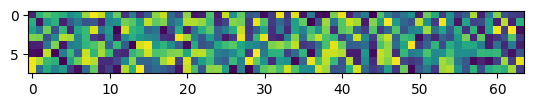

In [10]:
plt.imshow(input_sequence.detach().numpy())

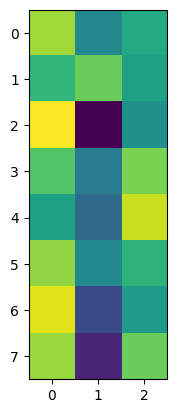

In [11]:
plt.imshow(classification_no_train.detach().numpy())

The output is random, as expected from the random initialization of the learnable parameters.

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define your model
num_classes = 3
vocab_size = 10000
batch_size = 8
d_model = 512
num_heads = 8
num_layers = 6
d_ff = 2048
sequence_length = 64
dropout = 0.1

#input_sequence = torch.randint(0, vocab_size, (batch_size, sequence_length))
#mask = torch.randint(0, 2, (sequence_length, sequence_length))

encoder = TransformerEncoder(vocab_size, d_model, num_layers, num_heads, d_ff, dropout, max_sequence_length=sequence_length)
classifier = ClassifierHead(d_model, num_classes)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(list(encoder.parameters()) + list(classifier.parameters()), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    optimizer.zero_grad()
    output = encoder(input_sequence, mask)
    classification = classifier(output)

    # Assuming you have ground truth labels as 'targets'
    targets = torch.randint(0, num_classes, (batch_size,))
    loss = criterion(classification, targets)

    loss.backward()
    optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# After training, you can print the classification results
print("Classification outputs for a batch of", batch_size, "sequences:")
print(classification)

Epoch [1/10], Loss: 0.7984
Epoch [2/10], Loss: 4.5634
Epoch [3/10], Loss: 9.0654
Epoch [4/10], Loss: 2.3856
Epoch [5/10], Loss: 2.0482
Epoch [6/10], Loss: 4.2777
Epoch [7/10], Loss: 3.2620
Epoch [8/10], Loss: 1.2600
Epoch [9/10], Loss: 1.3995
Epoch [10/10], Loss: 1.1762
Classification outputs for a batch of 8 sequences:
tensor([[-1.1156, -1.6686, -0.7261],
        [-0.9897, -1.5805, -0.8617],
        [-1.3808, -1.6927, -0.5717],
        [-1.2781, -1.6242, -0.6456],
        [-1.1045, -1.6854, -0.7272],
        [-1.2882, -1.6726, -0.6228],
        [-1.1993, -1.7213, -0.6544],
        [-1.2404, -1.6762, -0.6470]], grad_fn=<LogSoftmaxBackward0>)


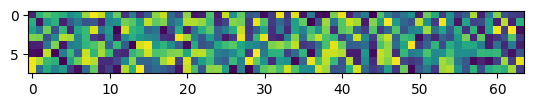

In [13]:
plt.imshow(input_sequence)

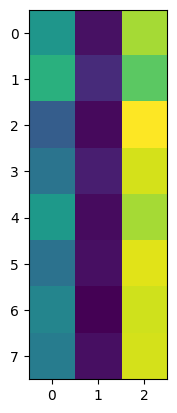

In [14]:
plt.imshow(classification.detach().numpy())

We have not arranged any viable feature for the input to the transformer model, so it is not possible to distinguish any of the inputs. However, it is plausible that three classes will align after some training. And here we are observing that classes somewhat align

Note: Although a random input sequence and mask are being used here, in practice, the mask should correspond to the actual location of padding tokens in the input sequences to ensure all of them are the same length.

We will come back to this mask again later to compare it with a causal mask.

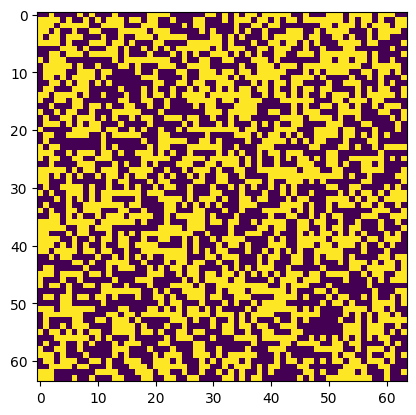

In [15]:
plt.imshow(mask)

## Decoder Transformer
Used for tasks like text generation, where the model generates text for a given input or prompt. Text generation occurs as a word at a time and conditions on itself (previously generated content) to generate new ones. GPT-3 (Generative Pre-trained Transformer 3) is a well-known Decoder Transformer.

<div>
<img src="https://github.com/caglarmert/DI725/blob/main/src/decoder_only_transformer.png?raw=true" width="300"/>
</div>




### Exercise 2.8: Decoder Layer

The encoder layer is built similarly; what is the main difference between these two structures?


#### Instructions
* A multi-headed self-attention mechanism.
* A feed-forward sublayer.
* Normalization and dropout are to be applied.

In [16]:
class DecoderLayer(nn.Module):
    """
    Decoder layer module.

    Args:
        d_model (int): Dimensionality of the input and output feature vectors.
        num_heads (int): Number of attention heads.
        d_ff (int): Dimensionality of the intermediate hidden layer in the feed-forward sub-layer.
        dropout (float): Dropout probability.

    Attributes:
        self_attention (MultiHeadAttention): Multi-head self-attention mechanism.
        norm1 (torch.nn.LayerNorm): Layer normalization for the first sub-layer.
        feed_forward (FeedForwardSubLayer): Feed-forward sub-layer.
        norm2 (torch.nn.LayerNorm): Layer normalization for the second sub-layer.
        dropout (torch.nn.Dropout): Dropout layer.
    """

    def __init__(self, d_model, num_heads, d_ff, dropout):
        """
        Initialize decoder layer with multi-head self-attention and feed-forward sub-layer.
        """
        super(DecoderLayer, self).__init__()
        # Multi-head self-attention
        self.self_attention = MultiHeadAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model)
        # Feedforward neural network
        self.feed_forward = FeedForwardSubLayer(d_model, d_ff)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, self_mask):
        """
        Forward pass of the decoder layer.

        Args:
            x (torch.Tensor): Input tensor.
            self_mask (torch.Tensor): Mask tensor for self-attention mechanism.

        Returns:
            torch.Tensor: Output tensor after applying multi-head self-attention and feed-forward sub-layer.
        """
        # Multi-head self-attention
        attention_output = self.self_attention(x, x, x, self_mask)
        x = x + self.dropout(attention_output)
        x = self.norm1(x)

        # Feedforward neural network
        ff_output = self.feed_forward(x)
        x = x + self.dropout(ff_output)
        x = self.norm2(x)

        return x

### Exercise 2.9: Building a decoder body and head

A high-level structure for a decoder-only transformer will be implemented in this exercise. Unlike the encoder transformer, the model body and head are not separated in the decoder transformer. Instead, the decoder transformer contains the model head and body. The model body is a stack of decoder layers.

#### Instructions
* Add the linear layer for the model head inside the TransformerDecoder class.
* Apply the last stage of the forward pass through the model head.

In [17]:
class TransformerDecoderOnly(nn.Module):
    """
    Transformer decoder-only module for next-element prediction.

    Args:
        vocab_size (int): Vocabulary size.
        d_model (int): Dimensionality of the input and output feature vectors.
        num_layers (int): Number of decoder layers.
        num_heads (int): Number of attention heads.
        d_ff (int): Dimensionality of the intermediate hidden layer in the feed-forward sub-layer.
        dropout (float): Dropout probability.
        max_sequence_length (int): Maximum sequence length for positional encoding.

    Attributes:
        embedding (torch.nn.Embedding): Embedding layer.
        positional_encoding (PositionalEncoding): Positional encoding layer.
        layers (torch.nn.ModuleList): List of decoder layers.
        fc (torch.nn.Linear): Linear layer for next-word prediction.
    """
    def __init__(self, vocab_size, d_model, num_layers, num_heads, d_ff, dropout, max_sequence_length):
        """
        Initialize transformer decoder-only with embedding, positional encoding, decoder layers, and linear layer for next-element prediction.
        """
        super(TransformerDecoderOnly, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model = d_model, max_len = max_sequence_length)
        self.layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        # Add a linear layer (head) for next-word prediction
        self.fc = nn.Linear(d_model, vocab_size)

    def forward(self, x, self_mask):
        """
        Forward pass of the transformer decoder-only for next-word prediction.

        Args:
            x (torch.Tensor): Input tensor.
            self_mask (torch.Tensor): Mask tensor for self-attention mechanism.

        Returns:
            torch.Tensor: Log probabilities of the next words in the vocabulary.
        """
        x = self.embedding(x)
        x = self.positional_encoding(x)
        for layer in self.layers:
            x = layer(x, self_mask)

        # Apply the forward pass through the model head
        x = self.fc(x)
        return F.log_softmax(x, dim=-1)

### Exercise 2.10: Testing the decoder transformer

A random and simple sequence will be used as an input to the decoder transformer. Obtaining the output without any errors is sufficient for this exercise.

The following components are adequate to form a full decoder transformer:
* PositionalEncoder
* MultiHeadAttention
* FeedForwardSublayer
* DecoderLayer
* TransformerDecoder

#### Instructions
* Implement the decoder transformer with methods and classes defined before.
* Complete the forward pass throughout the entire transformer body and head to obtain and print outputs.

In [18]:
vocab_size = 8
batch_size = 8
d_model = 16
num_heads = 1
num_layers = 6
d_ff = 32
sequence_length = 8
dropout = 0.1

input_sequence = torch.arange(0, sequence_length).unsqueeze(0).repeat(batch_size, 1)

# Create a triangular attention mask for causal attention
self_attention_mask = (1 - torch.triu(torch.ones(1, sequence_length, sequence_length), diagonal=1)).bool()
print("The input sequence")
print(input_sequence)



The input sequence
tensor([[0, 1, 2, 3, 4, 5, 6, 7],
        [0, 1, 2, 3, 4, 5, 6, 7],
        [0, 1, 2, 3, 4, 5, 6, 7],
        [0, 1, 2, 3, 4, 5, 6, 7],
        [0, 1, 2, 3, 4, 5, 6, 7],
        [0, 1, 2, 3, 4, 5, 6, 7],
        [0, 1, 2, 3, 4, 5, 6, 7],
        [0, 1, 2, 3, 4, 5, 6, 7]])


In [19]:
# Instantiate the decoder transformer
decoder = TransformerDecoderOnly(vocab_size, d_model, num_layers, num_heads, d_ff, dropout, max_sequence_length=sequence_length)

output = decoder(input_sequence, self_attention_mask)
print("Shape of our output:")
print(output.shape)
print("The first output we get:")
#print(output)

def find_largest_index(arr):
    max_index = 0
    for i in range(1, len(arr)):
        if arr[i] > arr[max_index]:
            max_index = i
    return max_index

for i in output:
  print(find_largest_index(i.detach().numpy()[0]))

Shape of our output:
torch.Size([8, 8, 8])
The first output we get:
6
6
6
6
6
6
6
6


Let's modify the decoder-transformer to be able to ouput a single value for a given sequence:

In [20]:
decoder = TransformerDecoderOnly(vocab_size, d_model, num_layers, num_heads, d_ff, dropout, max_sequence_length=sequence_length)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(decoder.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    optimizer.zero_grad()
    output = decoder(input_sequence, self_attention_mask)

    # Flatten the output and target tensors to have a consistent shape
    output_flat = output.view(-1, batch_size)
    target_flat = input_sequence.view(-1)

    # Compute the loss
    loss = criterion(output_flat, target_flat)

    # Backpropagation and optimization step
    loss.backward()
    optimizer.step()

    # Print the loss
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

Epoch [1/10], Loss: 2.012310028076172
Epoch [2/10], Loss: 1.9606823921203613
Epoch [3/10], Loss: 1.9396768808364868
Epoch [4/10], Loss: 1.8573246002197266
Epoch [5/10], Loss: 1.7921923398971558
Epoch [6/10], Loss: 1.7225502729415894
Epoch [7/10], Loss: 1.6462806463241577
Epoch [8/10], Loss: 1.605931043624878
Epoch [9/10], Loss: 1.5519427061080933
Epoch [10/10], Loss: 1.5158100128173828


In [21]:
for i in output:
  print(find_largest_index(i.detach().numpy()[0]))

0
0
0
0
0
0
0
0


The triangular mask defined here is the causal mask that prohibits the decoder from observing the "future" or cheating. For the first element in the sequence, the decoder can only observe the first element; for the second, the second and the first; and for the nth element, the decoder can only observe elements (tokens) up to the nth element, basically the last generated element and all previous ones.

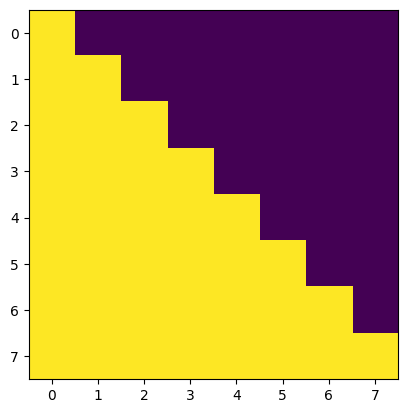

In [22]:
plt.imshow(self_attention_mask[0])

## Encoder-Decoder Transformer
It is useful for translation tasks where a given input text is required to be translated into an output in a target language. T5 (Text-to-Text Transfer Transformer) is a well-known encoder-decoder transformer that can also do summarization, question answering, and translation.

### Exercise 2.11: Incorporating cross-attention in a decoder

In an encoder-decoder transformer, decoder layers incorporate two attention mechanisms: the causal attention inherent to any transformer decoder and a cross-attention that integrates source sequence information processed by the encoder with the target sequence information being processed through the decoder.


<div>
<img src="https://github.com/caglarmert/DI725/blob/main/src/Cross_attention.png?raw=true" width="400"/>
</div>


Modify the DecoderLayer class to incorporate this two-fold attention scheme.

#### Instructions
* Initialize the two attention mechanisms used in an encoder-decoder transformer's decoder layer: causal (masked) self-attention and cross-attention.
* Pass the necessary input arguments (query, key, values, and mask) to the two attention stages in the forward pass.

In [23]:
class DecoderLayer(nn.Module):
    """
    Decoder layer module.

    Args:
        d_model (int): Dimensionality of the input and output feature vectors.
        num_heads (int): Number of attention heads.
        d_ff (int): Dimensionality of the intermediate hidden layer in the feed-forward sub-layer.
        dropout (float): Dropout probability.

    Attributes:
        self_attn (MultiHeadAttention): Multi-head self-attention mechanism.
        cross_attn (MultiHeadAttention): Multi-head cross-attention mechanism.
        feed_forward (FeedForwardSubLayer): Feed-forward sub-layer.
        norm1 (torch.nn.LayerNorm): Layer normalization for the first sub-layer.
        norm2 (torch.nn.LayerNorm): Layer normalization for the second sub-layer.
        norm3 (torch.nn.LayerNorm): Layer normalization for the third sub-layer.
        dropout (torch.nn.Dropout): Dropout layer.
    """
    def __init__(self, d_model, num_heads, d_ff, dropout):
        """
        Initialize decoder layer with multi-head self-attention, multi-head cross-attention, and feed-forward sub-layer.

        Args:
            d_model (int): Dimensionality of the input and output feature vectors.
            num_heads (int): Number of attention heads.
            d_ff (int): Dimensionality of the intermediate hidden layer in the feed-forward sub-layer.
            dropout (float): Dropout probability.
        """
        super(DecoderLayer, self).__init__()

        # Initialize the causal (masked) self-attention and cross-attention
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = FeedForwardSubLayer(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, causal_mask, encoder_output, cross_mask):
        """
        Forward pass of the decoder layer.

        Args:
            x (torch.Tensor): Input tensor.
            causal_mask (torch.Tensor): Mask tensor for causal self-attention mechanism.
            encoder_output (torch.Tensor): Encoder output tensor.
            cross_mask (torch.Tensor): Mask tensor for cross-attention mechanism.

        Returns:
            torch.Tensor: Output tensor after applying multi-head self-attention, multi-head cross-attention, and feed-forward sub-layer.
        """
        # Pass the necessary arguments to the causal self-attention and cross-attention
        self_attn_output = self.self_attn(x, x, x, causal_mask)
        x = self.norm1(x + self.dropout(self_attn_output))
        cross_attn_output = self.cross_attn(x, encoder_output, encoder_output, cross_mask)
        # (query, key, values, and mask)
        x = self.norm2(x + self.dropout(cross_attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x

### Exercise 2.12: Updating Decoder Transformer

In [24]:
class TransformerDecoder(nn.Module):
    """
    Transformer decoder module.

    Args:
        vocab_size (int): Vocabulary size.
        d_model (int): Dimensionality of the input and output feature vectors.
        num_layers (int): Number of decoder layers.
        num_heads (int): Number of attention heads.
        d_ff (int): Dimensionality of the intermediate hidden layer in the feed-forward sub-layer.
        dropout (float): Dropout probability.
        max_sequence_length (int): Maximum sequence length for positional encoding.

    Attributes:
        embedding (torch.nn.Embedding): Embedding layer.
        positional_encoding (PositionalEncoding): Positional encoding layer.
        layers (torch.nn.ModuleList): List of decoder layers.
    """
    def __init__(self, vocab_size, d_model, num_layers, num_heads, d_ff, dropout, max_sequence_length):
        """
        Initialize transformer decoder with embedding, positional encoding, and decoder layers.
        """
        super(TransformerDecoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model = d_model, max_len = max_sequence_length)
        self.layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

    def forward(self, x, causal_mask, encoder_output, cross_mask):
        """
        Forward pass of the transformer decoder.

        Args:
            x (torch.Tensor): Input tensor.
            causal_mask (torch.Tensor): Mask tensor for causal self-attention mechanism.
            encoder_output (torch.Tensor): Encoder output tensor.
            cross_mask (torch.Tensor): Mask tensor for cross-attention mechanism.

        Returns:
            torch.Tensor: Output tensor after decoding.
        """
        x = self.embedding(x)
        x = self.positional_encoding(x)
        for layer in self.layers:
            x = layer(x, causal_mask, encoder_output, cross_mask)
        return x

### Exercise 2.13: Trying out an encoder-decoder transformer
Your next task is to complete the following piece of code to define and forward-pass an example batch of randomly generated input sequences through an encoder-decoder transformer.

Remember that we are only testing a yet-to-be-trained transformer architecture, hence the use of random input sequences.

The following components are required to form a full encoder-decoder transformer:
* MultiHeadAttention
* FeedForwardSubLayer
* PositionalEncoding
* EncoderLayer
* DecoderLayer
* TransformerEncoder
* TransformerDecoder
* ClassifierHead


#### Instructions

* Create a batch of random input sequences of size batch_size X sequence_length.
* Instantiate the two transformer bodies using the appropriate class names.
* Pass the necessary masks as arguments to the encoder and the decoder for their underlying attention mechanisms; each mask argument should be added in the same order they are utilized inside the encoder or decoder layer.

In [43]:
vocab_size = 8
batch_size = 1
d_model = 8
num_heads = 8
num_layers = 6
d_ff = 16
sequence_length = 8
dropout = 0.1


# Create a batch of random input sequences
#input_sequence = torch.randint(0, vocab_size, (batch_size, sequence_length))

input_sequence = torch.arange(0, sequence_length).unsqueeze(0).repeat(batch_size, 1)

padding_mask = torch.randint(0, 2, (sequence_length, sequence_length))
causal_mask = torch.triu(torch.ones(sequence_length, sequence_length), diagonal=1)

# Instantiate the two transformer bodies
encoder = TransformerEncoder(vocab_size, d_model, num_layers, num_heads, d_ff, dropout, max_sequence_length=sequence_length)
decoder = TransformerDecoder(vocab_size, d_model, num_layers, num_heads, d_ff, dropout, max_sequence_length=sequence_length)

# Pass the necessary masks as arguments to the encoder and the decoder
encoder_output = encoder(input_sequence, padding_mask)
decoder_output = decoder(input_sequence, causal_mask, encoder_output, padding_mask)
print("Batch's output shape: ", decoder_output.shape)

Batch's output shape:  torch.Size([1, 8, 8])


Let's check the causal mask for the Encoder-Decoder Transformer

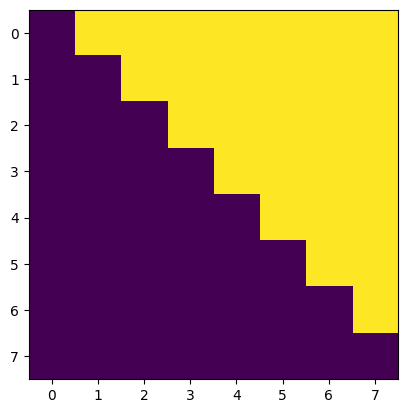

In [40]:
plt.imshow(causal_mask)

As we have seen in Decoder-Transformer, the causal mask is again a diagonal matrix that disables the capability of the Decoder part to see the future elements in a sequence.

In [48]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.001)
target_sequence = input_sequence.roll(2)
print("Input sequence")
print(input_sequence[0])
print("Target sequence (Translated)")
print(target_sequence[0])
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    optimizer.zero_grad()
    encoder_output = encoder(input_sequence, padding_mask)
    decoder_output = decoder(input_sequence, causal_mask, encoder_output, padding_mask)
    loss = criterion(decoder_output.view(-1, vocab_size), target_sequence.view(-1))
    loss.backward()
    optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

print("Batch's output shape: ", decoder_output.shape)
print("Output sequence:")


print(decoder_output)

Input sequence
tensor([0, 1, 2, 3, 4, 5, 6, 7])
Target sequence (Translated)
tensor([6, 7, 0, 1, 2, 3, 4, 5])
Epoch [1/10], Loss: 1.5360623598098755
Epoch [2/10], Loss: 1.2963014841079712
Epoch [3/10], Loss: 1.4941062927246094
Epoch [4/10], Loss: 1.2509400844573975
Epoch [5/10], Loss: 1.3432285785675049
Epoch [6/10], Loss: 1.2130272388458252
Epoch [7/10], Loss: 1.4588944911956787
Epoch [8/10], Loss: 1.2850843667984009
Epoch [9/10], Loss: 1.1765985488891602
Epoch [10/10], Loss: 1.0865533351898193
Batch's output shape:  torch.Size([1, 8, 8])
Output sequence:
tensor([[[ 0.4860, -0.4134, -0.3374, -0.2117,  0.4447, -0.0075,  1.9787,
          -1.8795],
         [-0.2459,  0.7748, -1.1490,  0.8151,  0.1305,  0.5500, -1.9239,
           1.0402],
         [ 1.4748, -2.3172,  0.1595,  0.3458,  0.3596,  0.3298, -0.4330,
           0.0797],
         [-0.2624,  2.2460, -0.8528,  0.6607,  0.1831,  0.0437, -0.9323,
          -1.0200],
         [ 0.0594, -1.3513,  2.3069, -0.2692,  0.3311, -0.0823, -

In [45]:
decoder_output

tensor([[[-0.0913, -0.8086, -0.7128,  1.7192, -0.6575,  1.3824,  0.3014,
          -1.1346],
         [ 0.2338, -0.4850,  0.7448,  1.1701,  0.1801,  1.0284, -1.9044,
          -0.9604],
         [ 0.0445, -1.1832, -0.4213,  0.5454, -0.5995,  0.6035, -1.0103,
           2.0667],
         [ 0.1964, -0.3723,  0.0992,  1.3224, -0.3444,  1.3633, -1.9458,
          -0.3030],
         [ 0.1757, -1.6825,  1.1730,  1.3938,  0.1035,  0.4107, -0.3964,
          -1.1766],
         [-1.2178, -1.3972, -0.3087,  0.5026, -0.1492,  1.3949, -0.2344,
           1.4320],
         [-0.7529, -1.4526, -0.7280,  0.8835,  0.1091,  1.5764, -0.5956,
           0.9810],
         [-0.1124, -1.1838,  0.7548, -0.6538,  0.2591,  0.1663, -1.1903,
           2.0044]]], grad_fn=<NativeLayerNormBackward0>)

In [ ]:
# Initialize positional encoding layer and stack of EncoderLayer modules
class TransformerEncoderOnly(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_len, dropout):
        super(TransformerEncoderOnly, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_len)
        self.layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        x = self.embedding(x)
        x = self.positional_encoding(x)
        x = self.dropout(x)

        # Pass the sequence through each layer in the encoder
        for layer in self.layers:
            x = layer(x, mask)

        return x

class TransformerModel(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_len, dropout):
        super(TransformerModel, self).__init__()
        # Initialize the encoder stack of the Transformer
        self.encoder = TransformerEncoderOnly(vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_len, dropout)

    def forward(self, src, src_mask):
        encoder_output = self.encoder(src, src_mask)
        return encoder_output

# Conclusion

In this exercise, we have seen the vanilla transformer from the paper Attention Is All You Need by Vaswani et al. and implemented its components from scratch with PyTorch. Experimenting with different hyperparameters that define the deep learning model architecture or training structure is highly recommended as an extra follow-up exercise!

We have seen three different implementations of transformers, namely the Encoder-Transformer, Decoder-Transformer and Encoder-Decoder (Vanilla) Transformer. We built them with basic building blocks and tested their input-output pipeline. We have also tested a very brief dummy training example that demonstrates the learning capability to some extent.

# Questions
1. What is the purpose of the mask (self_attention_mask) defined in 2.10?
1. Why do we use split heads in attention mechanism?
1. What is the difference between self attention and cross attention?
1.



# References
References and further tutorials to check out:
1. The paper, Attention is all you need, the transformer paper that introduced a whole new way of approaching deep learning: https://arxiv.org/abs/1706.03762
1. A solid blog that explains the Transformer architecture and its sub components: https://buomsoo-kim.github.io/attention/2020/04/19/Attention-mechanism-17.md/
1. Training a Transformer model, with a real dataset: https://buomsoo-kim.github.io/attention/2020/04/20/Attention-mechanism-18.md/
1. Further explanations on top of previous posts https://buomsoo-kim.github.io/attention/2020/04/21/Attention-mechanism-19.md/
1. Another Transformer tutorial: https://towardsdatascience.com/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1
1. The annotated Transformer, updated for newer version of PyTorch, an excellent guide that uses the original authors sentences and implement everything (just like we did in this tutorial): https://nlp.seas.harvard.edu/annotated-transformer/
1. PyTorch's documentation for Transformers and other helper libraries: https://pytorch.org/tutorials/beginner/transformer_tutorial.html
1. Dive into Deep Learning tutorial that uses their version of libraries, a different take on Transformer model implementation: https://d2l.ai/chapter_attention-mechanisms-and-transformers/self-attention-and-positional-encoding.html

